In [1]:
import numpy as np
import math as m
from matplotlib import pyplot as plt

In [2]:
a = 0
b = 1
h = 0.05
n = 21 # h = 0.05

# u" + p(x)u' + q(x)u = f(x)
# lft[0] * u'(a) + lft[1] * u(a) = lft[2]
# rgt[0] * u'(b) + rgt[1] * u(b) = rgt[2]

lft = [0, 1, 1]
rgt = [-2, 1, 0.1704]

nodes = np.linspace(a, b, n)

In [13]:
def U0_x(x):
    return m.sqrt(1+x)*m.sin(x) + m.e**(-x)
def p(x): 
    return 1 / (2*(1+x))
def q(x): 
    return -(1+2*x)/(2*(1+x))
def f(x): 
    return (3*m.cos(x) - (3+4*x)*m.sin(x))/(2*m.sqrt(1+x))

In [14]:
def tdma(left, right):
    """
    TriDiagonal Matrix Algorithm\n
    Решение СЛАУ с трехдиагональной матрицей. Важно диагональное преобладание.\n
    :param left: массив значений в левой части матрицы (все ненулевые элементы подряд построчно)
    :param right: правая часть матрицы
    :return: массив решений
    """
    n = 3
    if len(left) != (len(right) - 2) * n + 4:
        raise Exception("tdma method: something wrong with input\n")
    a_coef = np.zeros(len(right))
    b_coef = np.zeros(len(right))
    a_coef[0] = right[0] / left[0]
    b_coef[0] = -1 * left[1] / left[0]
    ind = n
    for i in range(1, len(right) - 1):
        a_coef[i] = (right[i] - left[ind - 1] * a_coef[i - 1]) / (left[ind] + left[ind - 1] * b_coef[i - 1])
        b_coef[i] = -1 * left[ind + 1] / (left[ind] + left[ind - 1] * b_coef[i - 1])
        ind += n
    a_coef[-1] = (right[-1] - left[ind - 1] * a_coef[-2]) / (left[ind] + left[ind - 1] * b_coef[-2])
    b_coef[-1] = 0.0

    res = np.zeros(len(right))
    res[-1] = a_coef[-1]
    for i in range(len(res) - 2, -1, -1):
        res[i] = a_coef[i] + b_coef[i] * res[i + 1]
    return res


def make_system(p, q, f, lft, rgt, nodes, order=1):
    if len(np.unique(np.diff(nodes).round(10))) != 1:
        raise Exception("make_system: grid must be uniform")
    h = nodes[1] - nodes[0]
    n = 3
    left = np.zeros((len(nodes) - 2) * n + 4)
    right = np.zeros(len(nodes))
    ind = n
    for i in range(1, len(nodes) - 1):
        left[ind - 1] = 1 - p(nodes[i]) * h / 2
        left[ind] = -2 + h * h * q(nodes[i])
        left[ind + 1] = 1 + h * p(nodes[i]) / 2
        right[i] = h * h * f(nodes[i])
        ind += n
    if order == 1:
        left[0] = lft[1] * h - lft[0]
        left[1] = lft[0]
        right[0] = lft[2] * h
        left[-2] = -1 * rgt[0]
        left[-1] = rgt[0] + h * rgt[1]
        right[-1] = rgt[2] * h
    elif order == 2:
        if lft[0] != 0:
            left[0] = -2 + 2 * h * lft[1] / lft[0] - p(nodes[0]) * lft[1] * h * h / lft[0] + q(nodes[0]) * h * h
            left[1] = 2
            right[0] = h * h * f(nodes[0]) + 2 * h * lft[2] / lft[0] - p(nodes[0]) * lft[2] * h * h / lft[0]
        else:
            left[0] = lft[1]
            left[1] = 0
            right[0] = lft[2]
        if rgt[0] != 0:
            left[-2] = 2
            left[-1] = -2 - 2 * h * rgt[1] / rgt[0] - p(nodes[-1]) * h * h * rgt[1] / rgt[0] + q(nodes[-1]) * h * h
            right[-1] = f(nodes[-1]) * h * h - 2 * h * rgt[2] / rgt[0] - p(nodes[-1]) * h * h * rgt[2] / rgt[0]
        else:
            left[-2] = 0
            left[-1] = rgt[1]
            right[-1] = rgt[2]
    else:
        raise Exception("make_system: only 1st or 2nd order")

    return left, right

In [17]:
left1, right1 = make_system(p, q, f, lft, rgt, nodes, order=1)
left2, right2 = make_system(p, q, f, lft, rgt, nodes, order=2)
res1 = tdma(left1, right1)
res2 = tdma(left2, right2)
real = [U0_x(i) for i in nodes]

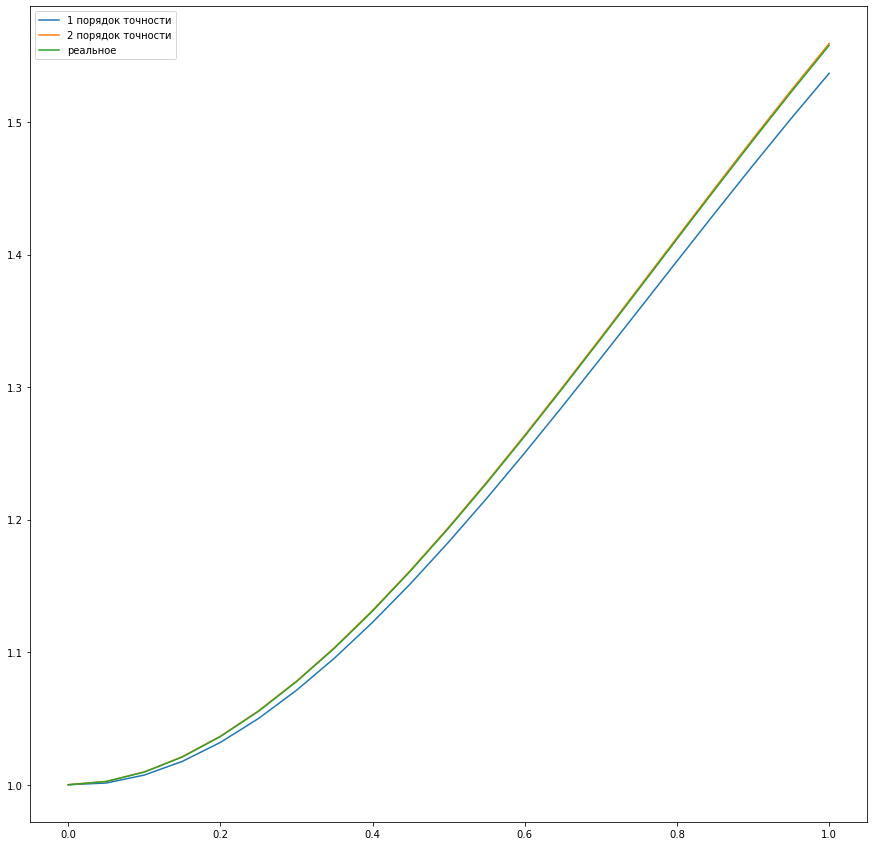

In [18]:
plt.rcParams["figure.figsize"] = (15,15)
plt.plot(nodes, res1, label='1 порядок точности')
plt.plot(nodes, res2, label='2 порядок точности')
plt.plot(nodes, real , label='реальное')

plt.legend()
plt.show()

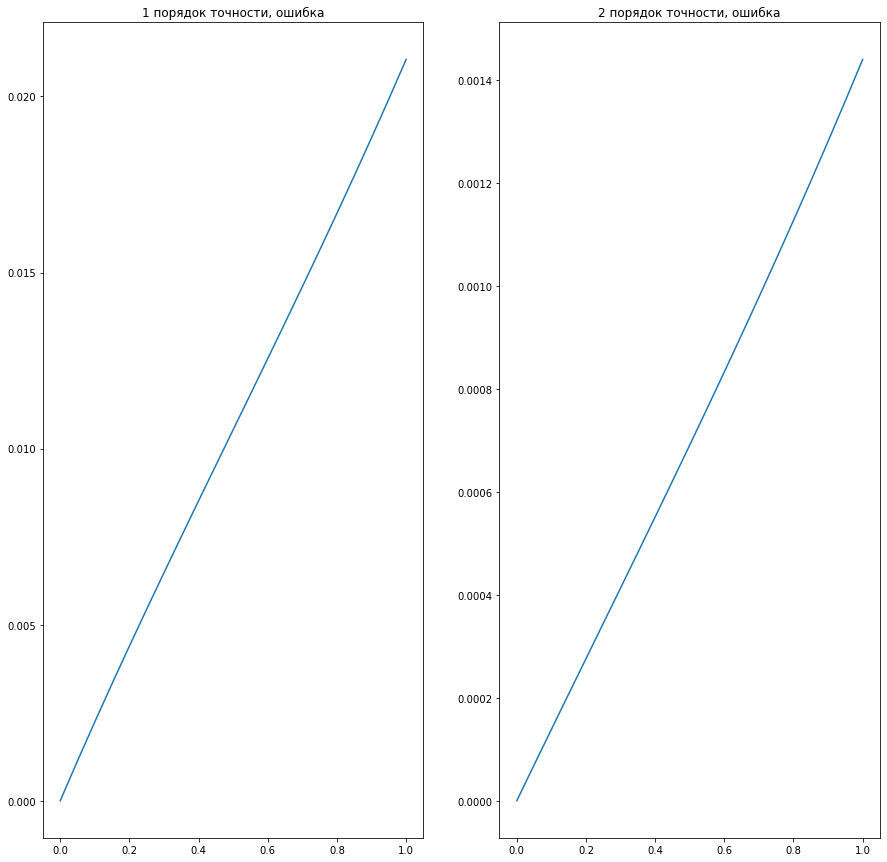

In [21]:
plt.subplot(1,2,1)
plt.title('1 порядок точности, ошибка')
plt.plot(nodes, np.abs(res1-real))

plt.subplot(1,2,2)
plt.title('2 порядок точности, ошибка')
plt.plot(nodes, np.abs(res2-real))

plt.show()

In [25]:
print("1 порядок точности, ошибка\n", np.abs(res1-real))
print("Средняя ошибка для 1го порядка:", np.mean(np.abs(res1-real)))
print("2 порядок точности, ошибка\n", np.abs(res2-real))
print("Средняя ошибка для 2го порядка:", np.mean(np.abs(res2-real)))

1 порядок точности, ошибка
 [0.         0.00113429 0.00224223 0.00332722 0.00439247 0.00544112
 0.00647614 0.00750044 0.00851683 0.00952805 0.01053677 0.01154562
 0.01255718 0.01357401 0.01459863 0.01563354 0.01668125 0.01774425
 0.01882504 0.01992613 0.02105007]
Средняя ошибка для 1го порядка: 0.010534822430825845
2 порядок точности, ошибка
 [0.00000000e+00 6.94916639e-05 1.38563970e-04 2.07357818e-04
 2.76003664e-04 3.44623426e-04 4.13332016e-04 4.82238600e-04
 5.51447649e-04 6.21059859e-04 6.91172945e-04 7.61882363e-04
 8.33281962e-04 9.05464589e-04 9.78522661e-04 1.05254870e-03
 1.12763586e-03 1.20387841e-03 1.28137225e-03 1.36021534e-03
 1.44050824e-03]
Средняя ошибка для 2го порядка: 0.0007019334281828634


In [24]:
#2 порядок точности дает более чем хорошие результаты, 
#наглядно видно увелечение ошибки с номером узла